# Assignment

In a production process of bricks there are 4 sensors ( s1 ,s2 ,s3 ,s4 ) which monitor the quality of each product. It is known that the sensor outputs are in a complex
relationship with two important characteristics of brick:

● Compressive Strength ( c )

● Flexure Strength ( f )

Company ran some tests and measured those characteristics on a limited set of
bricks. Data recorded from measurements and sensors is available in the file
dataset.csv. Each row in the dataset contains 6 numbers s1 , s2 , s3 , s4 , c and f. 
want to predict a value of c and f in order to detect bricks which do not satisfy
minimal required values. Prediction needs to work in real time, so performance of
the system is important.

# Solution
For the purpose of avoiding python/tensorflow version issues on the machine, a pre-prepared docker image was used as a development environment. The image is located here https://hub.docker.com/r/tensorflow/tensorflow/ and it is started with the command:
docker run -it --rm -v notebooks:/tf/notebooks -p 8888:8888 tensorflow/tensorflow:latest-jupyter
This image comes with python, tensorflow and jupyter notebook preinstalled.

## Task 1
Train a neural network (Keras or Tensorflow) which is going to predict values of c and f based on outputs from sensors. Use just two hidden layers with 20 neurons and Mean Absolute Error (MAE) loss function.

First we install additional packages.

In [120]:
!pip install -q keras
!pip install -q sklearn
!pip install -q pandas
!pip install -q seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Pyplot is included for generating charts, numpy for support functions and pandas to work with dataframes. mean_squared_error is also added to calculate the error later on to be able to compare different models. The assignment notes features as s but they are changed to x to differentiate between models in task4.
The dataset is loaded from csv and split into training/test. The training and testing data is split into features and labels. A neural network is defined with two hidden layers, each with 20 neurons, and the final layer which will have two outputs. The loss function is "mean absolute error".

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

column_names = ['x1', 'x2', 'x3', 'x4', 'c', 'f']
raw_data = pd.read_csv("dataset.csv", names=column_names, na_values='?')
data = raw_data.copy()
data.tail()

train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)

train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features[['c', 'f']].copy()
test_labels = test_features[['c', 'f']].copy()


train_features.pop('c')
train_features.pop('f')
test_features.pop('c')
test_features.pop('f')

dnn_model = tf.keras.Sequential([

      layers.Dense(20, activation='relu'),
      layers.Dense(20, activation='relu'),
      layers.Dense(2)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))



2.4.1


The model is trained in 100 epochs. 20% of the training data is reserved for validation.

In [122]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.19 s, sys: 907 ms, total: 10.1 s
Wall time: 9.82 s


The loss stabilizes around 80, 90. The training was tested with more epochs and validated, but 100 epochs was found as an optimal number between getting a good comparison on task 4 and not having overfitting.

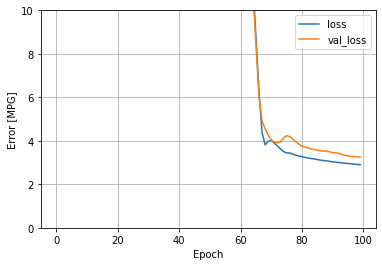

In [123]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

The model is evaluated on the test data. The overall loss is printed out to compare with results in task 4.

In [124]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(
    test_features, test_labels, verbose=1)
test_results

2/2 [==============================] - 0s 3ms/step - loss: 3.1038


{'dnn_model': 3.1037964820861816}

The MSE on test data is calculated on two outputs separately, also to be compared with results in task 4.

In [125]:
test_predictions = dnn_model.predict(test_features)
print("c MSE:%.4f" % mean_squared_error(test_labels['c'], test_predictions[:,0])) 
print("f MSE:%.4f" % mean_squared_error(test_labels['f'], test_predictions[:,1]))

c MSE:14.3489
f MSE:12.7634


Another plot is generated to show graphically how much is the prediction off the real test values. The dots are test data and the lines are predictions. 

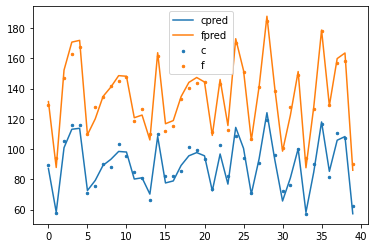

In [126]:
x_ax = range(len(test_features))
plt.scatter(x_ax, test_labels['c'],  s=6, label="c")
plt.plot(x_ax, test_predictions[:,0], label="cpred")
plt.scatter(x_ax, test_labels['f'],  s=6, label="f")
plt.plot(x_ax, test_predictions[:,1], label="fpred")
plt.legend()
plt.show()

The model is saved to be used for deployment in task 2.

In [148]:
saved_model_path = dnn_model.save(f"./mymodel", save_format='tf')

INFO:tensorflow:Assets written to: ./mymodel/assets


## Task 2
Try to improve model accuracy and compare results with the initial version. You
can assume that:

$c = s_{1} + s_{2}^{2} + 2s_{4}$

$f = s_{1} + s_{2}/2 + 3s_{4} + 30$

Expected sensor values are:

$s_{1} ∈[20, 50] s_{2} ∈ [0, 10], s_{3} ∈ [− 5, − 3], s_{4} ∈ [0, 1]$

For example, you can generate additional training data.
Create a new Docker image which is going to serve both models

A new function is created to generate the data based on expected sensor values. The uniform method is used to generate random data. A 1000 new samples is created (a new training set is generated only, in order to be able to compare the model results on the testing set which is the same for both models). 

In [130]:
from numpy import array
from numpy.random import uniform
from numpy import hstack

def create_data(n):
 s1 = array([uniform(0,10) for i in range(n)]).reshape(n,1)
 s2 = array([uniform(-5,-3) for i in range(n)]).reshape(n,1)
 s3 = array([uniform(0,1) for i in range(n)]).reshape(n,1)
 s4 = array([uniform(20,50) for i in range(n)]).reshape(n,1)

 c= [s1[i]+(s2[i]*s2[i])+2*s4[i] for i in range(n)]
 f= [s1[i]+s2[i]/2+3*s4[i]+30 for i in range(n)]
 X = hstack((s1, s2, s3, s4, c, f))
 return X

new_data = create_data(n=1000)
new_data

array([[  8.217,  -4.569,   0.13 ,  45.334, 119.763, 171.935],
       [  1.393,  -4.605,   0.908,  31.572,  85.739, 123.807],
       [  2.908,  -4.859,   0.108,  34.171,  94.863, 132.991],
       ...,
       [  9.013,  -3.69 ,   0.36 ,  28.406,  79.443, 122.386],
       [  7.385,  -3.545,   0.078,  26.531,  73.014, 115.206],
       [  0.745,  -3.54 ,   0.564,  20.355,  53.989,  90.039]])

In [131]:
new_data_df = pd.DataFrame(new_data, columns = ['s1','s2','s3','s4','c','f'])
new_data_df

,s1,s2,s3,s4,c,f
0,8.216941,-4.569241,0.129976,45.334072,119.763046,171.934538
1,1.392755,-4.604545,0.908322,31.572282,85.739150,123.807330
2,2.908187,-4.859351,0.107823,34.170677,94.862831,132.990542
3,9.220691,-4.273953,0.519201,32.629485,92.746338,134.972168
4,6.296141,-4.969454,0.705914,47.855211,126.702035,177.377046
...,...,...,...,...,...,...
995,6.658200,-4.922978,0.633689,38.070175,107.034267,148.407237
996,2.620035,-3.983911,0.703488,48.233986,114.959556,175.330038
997,9.012807,-3.690234,0.360063,28.405972,79.442575,122.385606
998,7.384629,-3.544970,0.078182,26.531450,73.014341,115.206492


Based on the cell above, the numbers seem to be in line with the train data in task 1 but a more determined analysis needs to be conducted:

In [133]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x1,160.0,4.712438,2.864573,0.005600,2.263625,4.498550,7.176775,9.955100
x2,160.0,-3.953631,0.593372,-5.000000,-4.438650,-3.970600,-3.466100,-3.000200
x3,160.0,0.498403,0.269256,0.025200,0.290625,0.486150,0.728175,0.965100
x4,160.0,34.763857,8.915345,20.002800,26.249875,35.590750,42.415025,49.995200
c,160.0,90.221242,18.264888,57.357117,73.668308,90.996986,106.224148,126.535945
f,160.0,137.027193,26.747671,90.129500,113.389912,137.797950,161.077187,186.236850


In [134]:
new_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s1,1000.0,5.094490,2.901264,0.013703,2.524648,5.136772,7.685824,9.979256
s2,1000.0,-4.013044,0.557758,-4.998759,-4.480675,-4.038734,-3.533838,-3.005971
s3,1000.0,0.491393,0.292304,0.001590,0.241028,0.485461,0.750462,0.999417
s4,1000.0,35.143414,8.756901,20.053961,27.124895,35.516021,42.636199,49.954977
c,1000.0,91.796623,18.158852,51.907606,76.763953,91.265161,106.947275,131.899995
f,1000.0,138.518210,26.354995,89.381249,115.193546,138.931653,161.068062,186.486909


A direct comparison can be done now by checking the mean, std, min and max values between the training data from task 1 and the new training data from task 4. The values are similar which means the sensor data is generated correctly and the c and f functions applied as stated in the task assignment. New features and labels need to be prepared:

In [135]:
new_train_features = new_data_df.copy()

new_train_labels = new_train_features[['c', 'f']].copy()


new_train_features.pop('c')
new_train_features.pop('f')

0      171.934538
1      123.807330
2      132.990542
3      134.972168
4      177.377046
          ...    
995    148.407237
996    175.330038
997    122.385606
998    115.206492
999     90.038764
Name: f, Length: 1000, dtype: float64

A new model is defined with the same parameters as in task 1:

In [138]:
dnn_model2 = tf.keras.Sequential([

      layers.Dense(20, activation='selu'),
      layers.Dense(20, activation='selu'),
      layers.Dense(2)
  ])

dnn_model2.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

The model is trained with the same validation split and the same number of epochs 100.

In [139]:
%%time
history = dnn_model2.fit(
    new_train_features, new_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12.1 s, sys: 2.72 s, total: 14.8 s
Wall time: 13 s


As expected, the model reaches better loss in the same number of epochs.

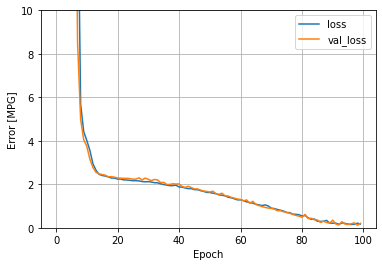

In [140]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

The loss is better than the model in task 1

In [141]:
test_results = {}

test_results['dnn_model_more_data'] = dnn_model2.evaluate(
    test_features, test_labels, verbose=1)
test_results

2/2 [==============================] - 0s 3ms/step - loss: 0.2256


{'dnn_model_more_data': 0.22558288276195526}

MSE on test data is lower as well.

In [142]:
test_predictions_more_data = dnn_model2.predict(test_features)
print("c MSE:%.4f" % mean_squared_error(test_labels['c'], test_predictions_more_data[:,0])) 
print("f MSE:%.4f" % mean_squared_error(test_labels['f'], test_predictions_more_data[:,1]))

c MSE:0.2038
f MSE:0.0096


The same chart with samples and predictions can be generated and it is clear that the new model follows the samples more closer.

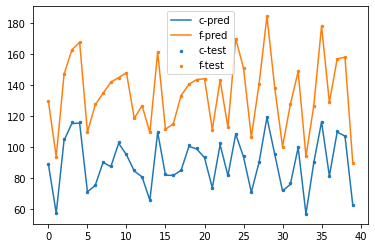

In [143]:
x_ax = range(len(test_features))
plt.scatter(x_ax, test_labels['c'],  s=6, label="c-test")
plt.plot(x_ax, test_predictions_more_data[:,0], label="c-pred")
plt.scatter(x_ax, test_labels['f'],  s=6, label="f-test")
plt.plot(x_ax, test_predictions_more_data[:,1], label="f-pred")
plt.legend()
plt.show()

The model is saved:

In [177]:
saved_model_path = dnn_model2.save(f"./mymodel_more", save_format='tf')

INFO:tensorflow:Assets written to: ./mymodel_more/assets


Connection to the host from jupyter notebook in containeris done by using the address host.docker.internal. The predictions need to be compared first for the same samples in test data:

In [191]:
import requests
import json
url1 = 'http://host.docker.internal:8501/v1/models/mymodel:predict'
url2 = 'http://host.docker.internal:8501/v1/models/mymodel_more:predict'

rows1 = []
rows2 = []
for index, row in test_features.iterrows():
    
    myobj = {'instances': [[row['x1'], row['x2'], row['x3'], row['x4']]]}

    x1 = requests.post(url1, json = myobj)
    x2 = requests.post(url2, json = myobj)
    json_data1 = json.loads(x1.text)
    json_data2 = json.loads(x2.text)
    
    rows1.append([json_data1['predictions'][0][0], json_data1['predictions'][0][1]])
    rows2.append([json_data2['predictions'][0][0], json_data2['predictions'][0][1]])
    
    print(f"{json_data1['predictions'][0]}:{json_data2['predictions'][0]}")
    
test_predictions_ws_mymodel = pd.DataFrame(rows1, columns=["c", "f"])
test_predictions_ws_mymodel_more = pd.DataFrame(rows2, columns=["c", "f"])

[87.1364441, 131.369186]:[88.8607941, 129.43309]
[58.3016281, 87.8033676]:[57.3722534, 93.808548]
[100.904274, 152.213913]:[104.267227, 146.896759]
[113.086533, 170.709183]:[115.177742, 162.736557]
[113.716797, 171.852097]:[115.494522, 167.66835]
[72.5611038, 109.44326]:[71.0849838, 109.638748]
[79.2571259, 119.966789]:[75.2575836, 127.285889]
[89.241, 134.76593]:[90.1205139, 134.696472]
[93.1929321, 140.976974]:[87.3772, 141.918793]
[98.4156647, 148.536942]:[102.457314, 144.856644]
[98.0200043, 148.130188]:[95.0638504, 147.967407]
[80.166069, 120.703018]:[84.6109238, 118.590446]
[80.9938889, 122.463112]:[80.7183762, 126.776108]
[70.2096176, 106.023705]:[65.6957245, 109.36869]
[108.260597, 163.691956]:[109.594765, 161.321747]
[77.5820694, 116.737732]:[81.8689117, 111.565674]
[78.9144897, 118.826302]:[81.7509, 114.938171]
[89.1483536, 134.651123]:[84.9538269, 133.308258]
[95.5348358, 144.078232]:[100.419991, 140.52533]
[97.6582184, 147.310883]:[98.8071289, 143.601685]
[95.5235672, 144.3

The predictions are different, which means that we are indeed getting data from two different models. By comparing the errors

In [188]:
print("mymodel: c MSE:%.4f" % mean_squared_error(test_labels['c'], test_predictions_ws_mymodel['c'])) 
print("mymodel: f MSE:%.4f" % mean_squared_error(test_labels['f'], test_predictions_ws_mymodel['f']))

mymodel: c MSE:14.3489
mymodel: f MSE:12.7634


In [189]:
print("mymodel_more: c MSE:%.4f" % mean_squared_error(test_labels['c'], test_predictions_ws_mymodel_more['c'])) 
print("mymodel_more: f MSE:%.4f" % mean_squared_error(test_labels['f'], test_predictions_ws_mymodel_more['f']))

mymodel_more: c MSE:0.2038
mymodel_more: f MSE:0.0096
